In [1]:
# Necessary imports
%load_ext autoreload
%autoreload 2\

import networkx as nx
import numpy as np
import tensorflow as tf

from keras import backend as K
from keras.layers import Dense
from keras.models import Model, Sequential


from TCGAMultiOmics.multiomics import MultiOmicsData
from moge.network.heterogeneous_network import HeterogeneousNetwork
from moge.visualization.plot_data import matrix_heatmap

from sklearn.metrics import pairwise_distances
np.set_printoptions(precision=2, suppress=True)

Using TensorFlow backend.


#  Import network from file

In [2]:
import pickle

# WRITE
# with open('moge/data/lncRNA_miRNA_mRNA/miRNA-mRNA_network_test_05_val_01_seed_0.pickle', 'wb') as file:
#     pickle.dump(network, file)

# READ
with open('moge/data/mirtarbase_lnc-mi/lmn_node05_d_u_train.pickle', 'rb') as file:
# with open('moge/data/lncRNA_miRNA_mRNA/miRNA-mRNA_network_biogrid.pickle', 'rb') as file:
    network = pickle.load(file)
#     network.remove_extra_nodes()
#     network.node_list = network.all_nodes
#     node_list = network.node_list

with open('moge/data/mirtarbase_lnc-mi/lmn_node05_d_u_val.pickle', 'rb') as file:
    network_test = pickle.load(file)

# Data Generator

In [3]:
batch_size = 1
input_shape = (None, 6)
max_length = 700

In [4]:
from moge.network.data_generator import DataGenerator

generator = DataGenerator(network=network, negative_sampling_ratio=2.0,
                          maxlen=max_length, padding='post', truncating="pre",
                          batch_size=1, dim=input_shape, 
                          shuffle=True, seed=0)
generator.genes_info = generator.genes_info[generator.genes_info["Transcript sequence"].notna()]

X, y = generator.__getitem__(0)
print("X:", [(k, v.shape) for k, v in X.items()], "\ny:", y.shape)

Genes info columns: ['locus_type', 'location', 'Family', 'Transcript sequence', 'Disease association', 'Transcript length']
Number of nodes without seq removed: 782
num_words: None {'A': 1, 'T': 2, 'G': 3, 'C': 4, 'U': 5}
Ed_count: 571156 , Eu_count: 203710 , En_count: 818722
Ens_count: 1142312
X: [('input_seq_j', (1, 700, 6)), ('input_seq_i', (1, 700, 6)), ('is_directed', (1, 1))] 
y: (1, 1)


# Load saved model to Siamese Graph Embedding

In [5]:
from moge.embedding.siamese_graph_embedding import SiameseGraphEmbedding
siamese = SiameseGraphEmbedding(d=64, batch_size=4096, lr=0.05, epochs=20, negative_sampling_ratio=5.0,
                                 max_length=700, truncating="post", verbose=True)
siamese.load_model("moge/data/mirtarbase_lnc-mi/models/lstm_512_nodes_randtrunc_weighted_e20.h5",
                  generator)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, 6)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 192)         7104      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 192)         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 320)         184640    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, None, 320)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 320)         0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 640)               1640960   
__________

/home/jonny/.conda/envs/jonny_conda3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [6]:
embs = siamese.get_embedding()

In [7]:
embs.shape

(32307, 512)

# Visualization

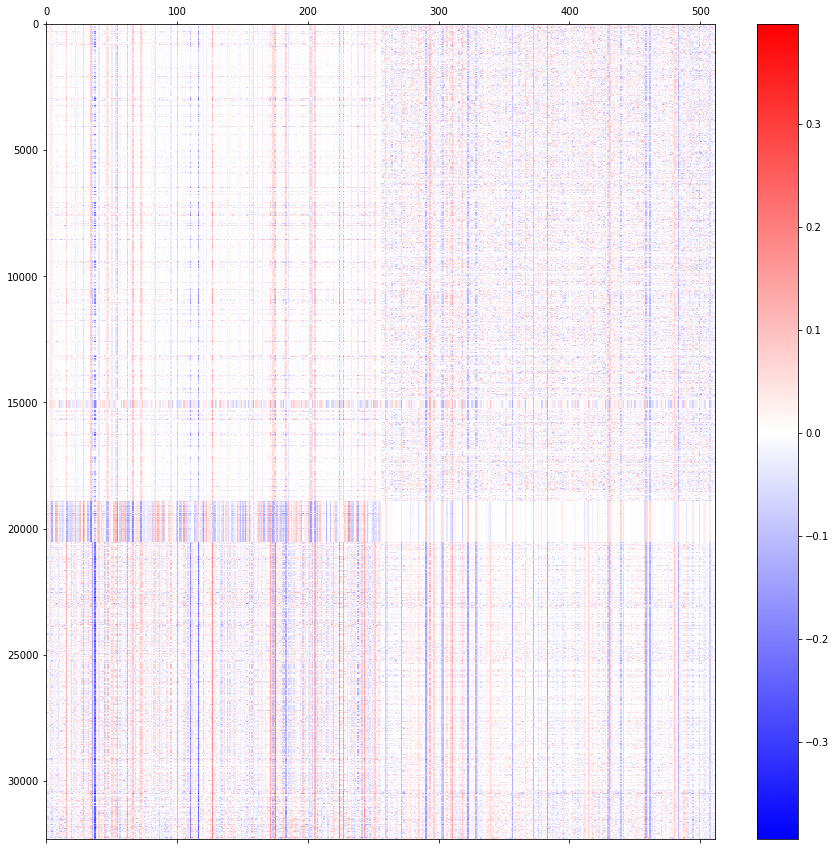

In [11]:
matrix_heatmap(embs, cmap="bwr", aspect='auto')

Embeddings filtered by node list (11769, 512)


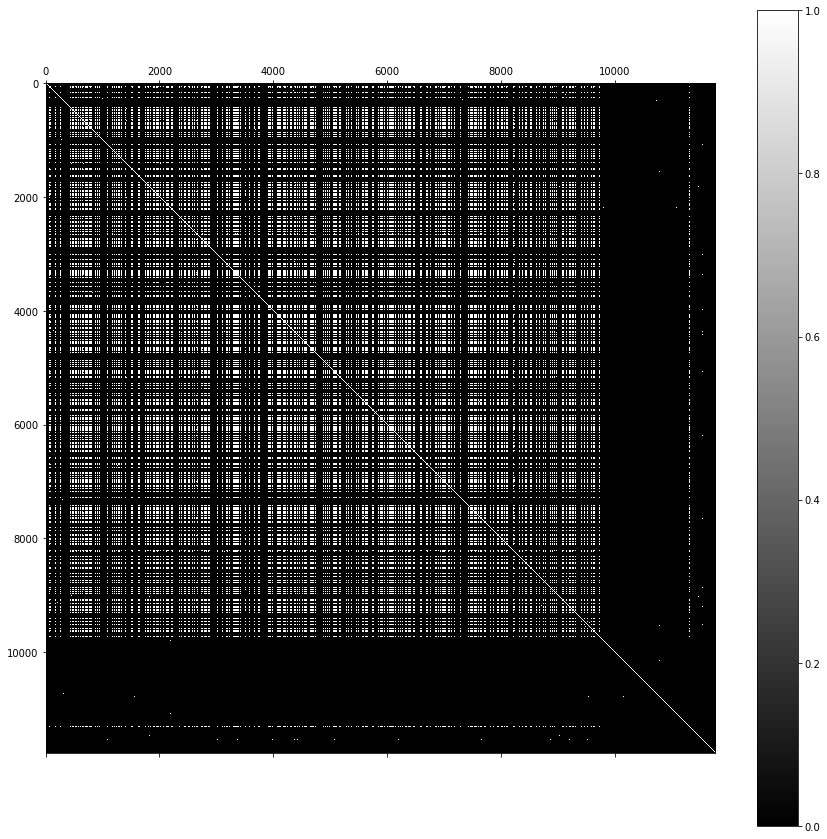

In [9]:
matrix_heatmap(siamese.get_reconstructed_adj(edge_type="u", node_l=network.nodes["LNC"]))

Embeddings filtered by node list (32307, 512)


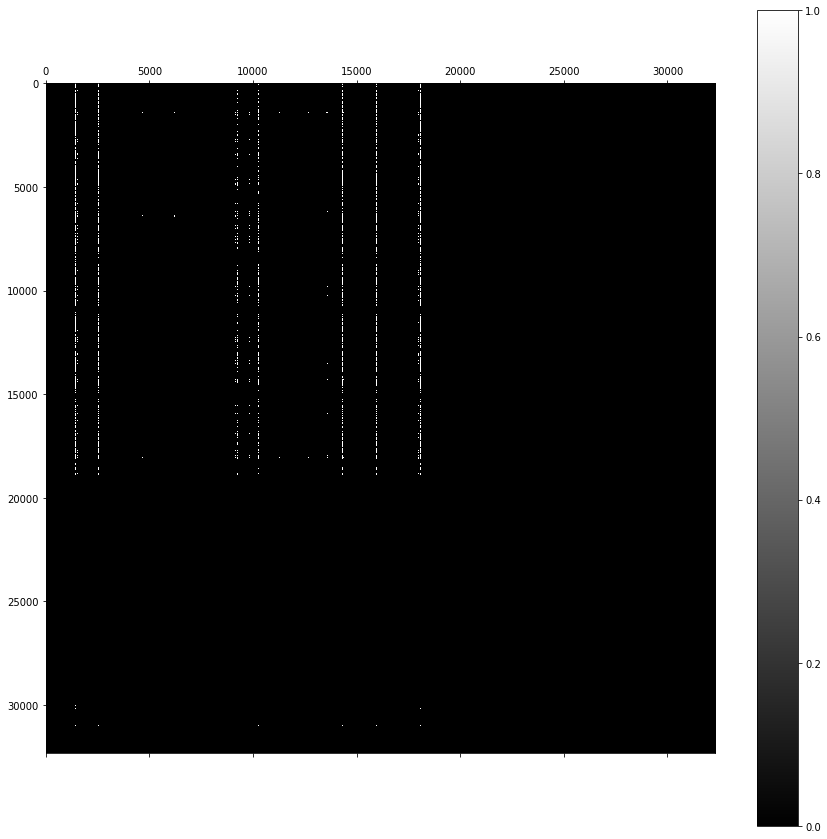

In [12]:
matrix_heatmap(siamese.get_reconstructed_adj(edge_type="d", node_l=generator.node_list, beta=5.0))

# Read/Write embedding to file

In [13]:
# Write embeddings to file
fout = open("moge/data/mirtarbase_lnc-mi/embeddings/node_train_512.emb", 'w')
fout.write("{} {}\n".format(len(generator.node_list), siamese._d))
for i in range(len(generator.node_list)):
    fout.write("{} {}\n".format(generator.node_list[i],
                                    ' '.join([str(x) for x in embs[i]])))
fout.close()

In [26]:
# Read embeddings from file
from moge.embedding.static_graph_embedding import ImportedGraphEmbedding
graph_emb = ImportedGraphEmbedding(d=512, method_name="siamese_switch")
graph_emb.import_embedding("moge/data/negative_sample_edges/Embeddings/lmn_512_trunc_700_nodes10.emb", 
                           node_list=generator.node_list)
embs = graph_emb._X
embs.shape

(32307, 512)

# Link Prediction

In [12]:
from moge.evaluation.link_prediction import select_top_k_link_predictions

top_pred_d_edges = select_top_k_link_predictions(50, siamese.get_reconstructed_adj(edge_type='d', 
                                                                                   node_l=network.nodes["GE"]),
                                                network.get_adjacency_matrix(edge_types=['d'], 
                                                                             node_list=network.nodes["GE"]))

Embeddings filtered by node list (18921, 64)


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

# Node Annotation prediction

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer, LabelBinarizer

label_name = "Disease association"
nodelist = generator.genes_info[generator.genes_info[label_name].notna()].index

# labels = generator.genes_info.loc[nodelist, label_name].str.split("|")
labels = generator.genes_info.loc[nodelist, label_name].str.split("|", expand=True)[0]
labeler = LabelBinarizer()
y = labeler.fit_transform(labels.tolist())

X = embs[[generator.genes_info.index.get_loc(node) for node in nodelist]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

print(X.shape, y.shape)
print(labeler.classes_)

(8137, 512) (8137, 1398)
['2,4-dienoyl-coa reductase deficiency'
 '3-@methylglutaconic aciduria, type v'
 '3-methylcrotonyl coa carboxylase 1 deficiency' ... 'wooly hair'
 'x-linked agammaglobulinemia with growth hormone deficiency'
 'xanthinuria, type ii']


In [19]:
from sklearn import svm
from sklearn.linear_model import RidgeClassifierCV, MultiTaskLasso
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

# clf = svm.LinearSVC(multi_class="crammer_singer")
clf = MLPClassifier(hidden_layer_sizes=(1000,100), activation="logistic", early_stopping=True, verbose=True)
# clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

Iteration 1, loss = 512.35380828
Validation score: 0.000000
Iteration 2, loss = 10.28602347
Validation score: 0.000000
Iteration 3, loss = 8.90482752
Validation score: 0.000000
Iteration 4, loss = 7.92643891
Validation score: 0.000000
Iteration 5, loss = 7.41280367
Validation score: 0.000000
Iteration 6, loss = 7.13800185
Validation score: 0.000000
Iteration 7, loss = 6.96909592
Validation score: 0.000000
Iteration 8, loss = 6.85526217
Validation score: 0.000000
Iteration 9, loss = 6.78929454
Validation score: 0.000000
Iteration 10, loss = 6.74964746
Validation score: 0.000000
Iteration 11, loss = 6.71654223
Validation score: 0.000000
Iteration 12, loss = 6.68717763
Validation score: 0.000000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=(1000, 100), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=True, warm_start=False)

In [16]:
from sklearn.metrics import f1_score

f1_score(y_test, clf.predict(X_test), pos_label=1, average='micro')

/home/jonny/.conda/envs/jonny_conda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.0

In [17]:
isolates = list(nx.isolates(network_test.G))
len(isolates)

7085

# Visualize Embeddings

In [20]:
from sklearn.metrics.pairwise import pairwise_distances
from moge.visualization.plot_data import matrix_heatmap
from scipy import sparse
# from sklearn.manifold import TSNE
from moge.visualization.visualize_embedding import get_node_color, plot_embedding2D
import matplotlib.pyplot as plt

In [21]:
from sklearn.decomposition import PCA

embs_pca = PCA(n_components=2).fit_transform(embs)

In [62]:
from MulticoreTSNE import MulticoreTSNE as TSNE

tsne = TSNE(init=embs_pca, perplexity=80, n_jobs=8, verbose=True)
node_pos = tsne.fit_transform(embs)

In [63]:
g = network.G.subgraph(generator.node_list)
# g = nx.relabel.relabel_nodes(g, {k: v for v, k in enumerate(generator.node_list)})

In [66]:
nodelist = generator.genes_info[generator.genes_info["Transcript sequence"].notnull()][
    generator.genes_info["locus_type"].isin([\
                                             "RNA, micro", 
                                             "RNA, long non-coding", 
                                             "protein_coding"
                                            ])].index.tolist()
# nodelist = generator.node_list
len(nodelist)

21841

In [67]:
edgelist = [(u,v) for u, v, d in network_test.G.edges(data=True) if (d["type"]=="d" and (u in nodelist and v in nodelist))]
np.random.shuffle(edgelist)
len(edgelist)

9150

In [68]:
generator.genes_info.columns

Index(['locus_type', 'location', 'Family', 'Transcript sequence',
       'Disease association', 'Transcript length'],
      dtype='object')

In [69]:
node_labels = generator.genes_info.loc[nodelist]["Family"] # "Transcript length", "locus_type", "Family"
n = 100
node_colormap = {f:float(hash(f) % n) / n for f in node_labels.unique()}
node_colors = [node_colormap[n] if n in node_colormap.keys() else 0 for n in node_labels]      

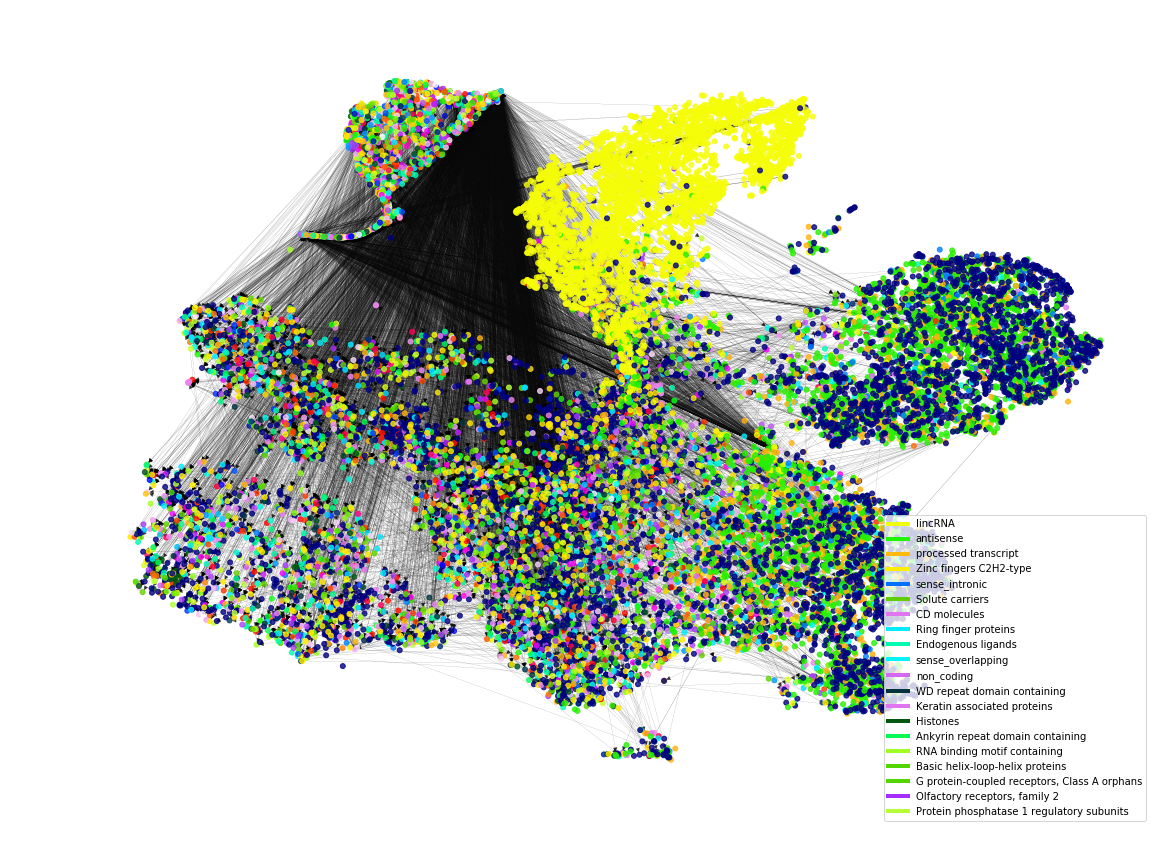

In [72]:
import matplotlib.colors as colors
import matplotlib.cm as cmx

plot_embedding2D(node_pos, node_list=generator.node_list, node_colors=node_colors,
                 legend=True, node_labels=node_labels, node_colormap=node_colormap, legend_size=20,
                 di_graph=g, cmap="gist_ncar", nodelist=nodelist,
                 plot_nodes_only=False, edgelist=edgelist, 
                 with_labels=False, figsize=(20,15)
                )
